Compare two approaches for estimating value $f_{0 \to 1}(\theta)$ and gradient $\nabla f_{0 \to 1}(\theta)$.


**Approach 1: Differentiable reweighting for both value and gradient**
* Estimate free energies of all available intermediate states between $0$ and $1$ by constructing an MBAR mixture
    * This requires computing the potential energy of all samples in all intermediate states
    * The quality of this estimate depends on the "overlap" between all pairs of intermediate states
* Estimate free energy of each endpoint relative to MBAR mixture by `-logsumexp(log_importance_weights)`
    * This requires computing the potential energy of all samples in a new target state
    * The quality of this estimate depends on the quality of the previous estimate, and on the "overlap" between the MBAR mixture and each target endstate
* Estimate gradient by expressing `log_importance_weights` as a differentiable function of $\theta$
* For fixed samples, these estimates are deterministic, and the estimated gradient is the exact gradient of the estimated value
    * For fixed samples, this allows use of generic optimizers or samplers that assume they are talking to a deterministic function
    * For fresh samples, this may still be a valuable processing step if it significantly reduces variance compared with an alternative estimator
    
**Approach 2: Plug-in thermodynamic integration (TI) estimator for value, plug-in thermodynamic derivative (TD) estimator for gradient**
* Estimate the TI expression $\int_0^1 d \lambda \langle du/d\lambda \rangle_\lambda$ by quadrature on a fixed grid of `lambdas`, with plug-in estimators for each average $\langle du/d\lambda \rangle_\lambda$
    * The quality of this estimate depends on the  curvature of $\langle du/d\lambda \rangle_\lambda$ as a function of $\lambda$, the spacing of `lambdas`, and the precision of each estimated average $\langle du/d\lambda \rangle_\lambda$.
* Estimate the TD expression $\langle d u / d \theta \rangle_1 - \langle d u / d \theta \rangle_0$ by sample averages at endpoints
    * The quality of this estimate is independent of the protocol definition or quality of sampling at intermediate states, but depends on the variance of $d u / d \theta$ in each endpoint
* The value estimator and gradient estimator become exactly consistent in the limit of infinite sampling and no quadrature error 

------------

*Note: These are not the only natural ways to compute the free energy and its gradient w.r.t. params on a collection of samples, and some variance reduction strategies are immediately applicable to one or the other of these two methods.*

*For example, a variance reduction strategy that can readily be applied to the TI and TD estimators---but is less obvious how to apply to the reweighting estimators---is the method of **control variates**. Since the TI and TD estimators are expressed in terms of simple averages, we could design or learn control variates for each of the averages we need to estimate. An example of this approach applied to TI is described in https://arxiv.org/abs/1404.5053 . To apply control variates to the TD estimator, we would find functions $g_0$, $g_1$ such that $\langle g_0 \rangle_0 = 0$ and $\langle g_1 \rangle_1 = 0$ (i.e. subtracting them won't impact ensemble averages in the end-states), and then replace the plug-in estimators of $\langle d u / d \theta \rangle_0$, $\langle d u / d \theta \rangle_1$ with plug-in estimators of $\langle d u / d \theta - g_0 \rangle_0$, $\langle d u / d \theta - g_1 \rangle_1$. Since the TI and TD estimators are expressed in terms of simple averages, it is clear how to apply control variates to improve the precision of each estimate of each average. In contrast, since the MBAR estimate isn't given by a simple average of some function, it is less obvious how to apply control variates to it.*

*Both approaches benefit from generic improvements such as optimized protocols and faster sampling (although at different rates), and here we fix the choice of protocol and assume perfect sampling.*

*It should also be noted that these two methods are not mutually exclusive, and could be combined if advantageous. For example, we could use reweighting to compute a "denoised" version of the TI curve, but then still use `np.trapz(denoised_ti_curve, lambdas)` to compute the final free energy estimate.*

In [1]:
from jax import grad, jit, vmap, value_and_grad, numpy as np, config
from jax.scipy.special import logsumexp
config.update("jax_enable_x64", True)

from fe.reweighting import ReweightingLayer, ESS # https://github.com/proteneer/timemachine/pull/404

import pymbar

from scipy.optimize import minimize, approx_fprime

from tqdm import tqdm

import numpy as onp
onp.random.seed(2021)

import matplotlib.pyplot as plt
%matplotlib inline

### Define testsystem and intermediates

Endstate 0 is uniform, endstate 1 is given by e to the minus Lennard-Jones potential

with intermediate distributions given by distance-based decoupling `r_eff = sqrt(r^2 + w^2); w = (1 - lam) * cutoff;`

In [2]:
sig, eps = 1.0, 2.0
ref_params = np.array([sig, eps])

cutoff = 5.0

In [3]:
def lennard_jones(r, sigma, epsilon):
    return 4 * epsilon * ( (sigma / r)**12 - (sigma / r)**6 )

In [4]:
def u_fxn(r, lam, params):
    sigma, epsilon = params
    
    w = (1 - lam) * cutoff
    r_eff = np.sqrt(r**2 + w**2)
    
    return np.sum(lennard_jones(r_eff, sigma, epsilon))

lambdas = np.linspace(0,1,60)
vmapped_u_fxn = vmap(u_fxn, (0, None, None))

#### Plot intermediates

Text(0, 0.5, 'probability density')

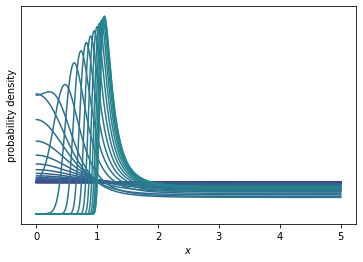

In [5]:
x_grid = np.linspace(0,cutoff,1000)[1:]

# TODO: better colors!
cmap = plt.get_cmap('viridis')
colors = cmap.colors[::2][:len(lambdas)]

for i, lam in enumerate(lambdas):
    y_ = np.exp(-vmapped_u_fxn(x_grid, lam, ref_params))
    y = y_ / np.trapz(y_, x_grid)
    plt.plot(x_grid, y, c=colors[i])

    
plt.xlabel('$x$')
plt.ylabel('$p(x; \lambda)$')
plt.yticks([])
plt.ylabel('probability density')

### Generate perfect samples for test system

In [6]:
def rejection_sample(lam, params, n_proposals=1000):
    """Generate a fixed number of proposals, and return a variable number of accepted samples"""
    
    proposals = onp.random.rand(n_proposals) * cutoff
    q = np.exp(-vmapped_u_fxn(proposals, lam, params))
    max_q = np.exp(params[1]) # exp(- U_min)
    accept_prob = q / max_q
    assert(accept_prob.max() <= 1.0)
    accept_mask = accept_prob > onp.random.rand(n_proposals)
    samples = proposals[accept_mask]
    return samples
    
def sample(lam, params, n_samples=10000, max_batched_attempts=10):
    """Generate a fixed number of accepted samples, by performing rejection sampling in batches
    until at least the target number of samples have been accepted"""
    
    sample_batches = [rejection_sample(lam, params, 5 * n_samples)]
    while sum(map(len, sample_batches)) < n_samples and len(sample_batches) < max_batched_attempts:
        sample_batches.append(rejection_sample(lam, params, 5 * n_samples))
    
    samples = np.hstack(sample_batches)[:n_samples]
    assert len(samples) == n_samples
    return samples

### Sample end-points

In [7]:
n_samples = 100000

x_0 = sample(0.0, ref_params, n_samples)
x_1 = sample(1.0, ref_params, n_samples)

Text(0.5, 1.0, 'endpoints')

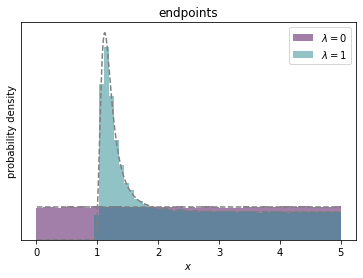

In [8]:
q_0 = np.exp(-vmapped_u_fxn(x_grid, 0.0, ref_params))
q_1 = np.exp(-vmapped_u_fxn(x_grid, 1.0, ref_params))

plt.hist(x_0, density=True, bins=50, alpha=0.5, label='$\lambda=0$', color=colors[0]);
plt.plot(x_grid, q_0 / np.trapz(q_0, x_grid), color='grey', linestyle='--')

plt.hist(x_1, density=True, bins=50, alpha=0.5, label='$\lambda=1$', color=colors[-1]);
plt.plot(x_grid, q_1 / np.trapz(q_1, x_grid), color='grey', linestyle='--')

plt.legend()

plt.xlabel('$x$')
plt.ylabel('$p(x)$')
plt.yticks([])
plt.ylabel('probability density')

plt.title('endpoints')

### Generate samples at all intermediates

In [9]:
n_samples_per_window = 1000
x_k = [sample(lam, ref_params, n_samples_per_window).reshape((n_samples_per_window, 1)) for lam in lambdas]
N_k = [n_samples_per_window for lam in lambdas]

### Construct reweighting layer

Usage: `layer.compute_delta_f(params)`

In [10]:
layer = ReweightingLayer(x_k, u_fxn, ref_params, lambdas)
layer.compute_delta_f(ref_params)

DeviceArray(-0.16097438, dtype=float64)

In [11]:
# also supports gradient w.r.t. params
delta_f, grad_delta_f = value_and_grad(layer.compute_delta_f)(ref_params)
delta_f, grad_delta_f

(DeviceArray(-0.16097438, dtype=float64),
 DeviceArray([-0.12332112, -0.30204044], dtype=float64))

In [12]:
%%time
_ = value_and_grad(layer.compute_delta_f)(ref_params)

CPU times: user 54.1 ms, sys: 7.5 ms, total: 61.6 ms
Wall time: 38.1 ms


### Define and minimize a loss in terms of `pred_delta_f` and `target_delta_f`

In [13]:
target_delta_f = -0.5

In [14]:
def loss(params):
    pred_delta_f = layer.compute_delta_f(params, ess_warn_threshold=0.0)
    return (pred_delta_f - target_delta_f)**2

def fun(params):
    v, g = value_and_grad(loss)(params)
    return float(v), onp.array(g)

result = minimize(fun, x0=ref_params, jac=True, tol=0)
result

      fun: 0.0
 hess_inv: array([[0.97871512, 0.11142221],
       [0.11142221, 1.51635582]])
      jac: array([0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 11
      nit: 7
     njev: 11
   status: 0
  success: True
        x: array([1.29169981, 2.68366644])

Text(0.5, 1.0, 'initial vs. optimized $\\lambda=1$ state')

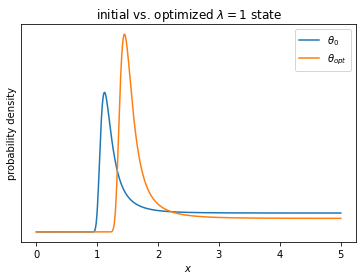

In [15]:
q_opt = np.exp(-vmapped_u_fxn(x_grid, 1.0, result.x))

plt.plot(x_grid, q_1 / np.trapz(q_1, x_grid), label=r'$\theta_0$')
plt.plot(x_grid, q_opt / np.trapz(q_opt, x_grid), label=r'$\theta_{opt}$')
plt.legend()

plt.xlabel('$x$')
plt.ylabel('$p(x)$')
plt.yticks([])
plt.ylabel('probability density')

plt.title('initial vs. optimized $\lambda=1$ state')

#### Double-check the number of effective samples available at optimized parameter set

In [16]:
log_weights = - vmapped_u_fxn(layer.xs, 1.0, ref_params) - layer.reference_log_weights
ESS(log_weights)

DeviceArray(35251.21624186, dtype=float64)

In [17]:
log_weights = - vmapped_u_fxn(layer.xs, 1.0, result.x) - layer.reference_log_weights
ESS(log_weights)

DeviceArray(16666.24576923, dtype=float64)

In [18]:
layer.compute_delta_f(result.x)

DeviceArray(-0.5, dtype=float64)

In [19]:
ESS(log_weights), len(layer.xs)

(DeviceArray(16666.24576923, dtype=float64), 60000)

Text(0.5, 1.0, 'rows of normalized overlap matrix')

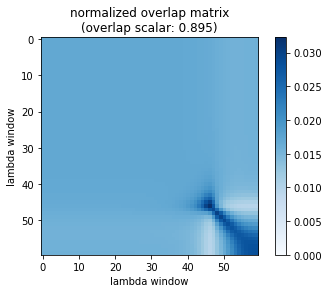

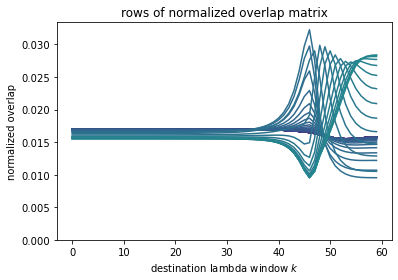

In [20]:
overlap_result = layer.mbar.computeOverlap()
overlap_scalar, overlap_matrix = overlap_result['scalar'], onp.array(overlap_result['matrix'])

plt.title(f'normalized overlap matrix\n(overlap scalar: {overlap_scalar.real:.3f})')
plt.imshow(overlap_matrix, cmap='Blues', vmin=0)
plt.xlabel('lambda window')
plt.ylabel('lambda window')
plt.colorbar()

plt.figure()
for i in range(len(lambdas)):
    plt.plot(overlap_matrix[i], c=colors[i]);
plt.ylim(0,)
plt.xlabel('destination lambda window $k$')
plt.ylabel('normalized overlap')
plt.title('rows of normalized overlap matrix')

### Compare with the result of ~ exact numerical quadrature

In [21]:
def delta_f_by_quadrature(params):
    trial_q_0 = np.exp(-vmapped_u_fxn(x_grid, 0.0, params))
    trial_q_1 = np.exp(-vmapped_u_fxn(x_grid, 1.0, params))
    return - (np.log(np.trapz(trial_q_1, x_grid)) - np.log(np.trapz(trial_q_0, x_grid)))

In [22]:
# at ref params
layer.compute_delta_f(ref_params), delta_f_by_quadrature(ref_params)

(DeviceArray(-0.16097438, dtype=float64),
 DeviceArray(-0.16267118, dtype=float64))

In [23]:
# at optimized params
layer.compute_delta_f(result.x), delta_f_by_quadrature(result.x)

(DeviceArray(-0.5, dtype=float64), DeviceArray(-0.49641567, dtype=float64))

### Thermodynamic derivative:
* Plug-in estimator for <du/dparams>_1 - <du/dparams>_0

In [24]:
vec_param_grads = jit(vmap(grad(u_fxn, 2), (0, None, None)))
param_grads = vec_param_grads(x_1, 1.0, ref_params)
du_dsig, du_deps = param_grads.T

In [25]:
np.std(du_dsig), np.std(du_deps)

(DeviceArray(6.37693445, dtype=float64),
 DeviceArray(0.38097334, dtype=float64))

Inspect distribution of parameter derivatives evaluated on each sample $x_i$ (in later steps, we will compute raw or weighted averages of these quantities)

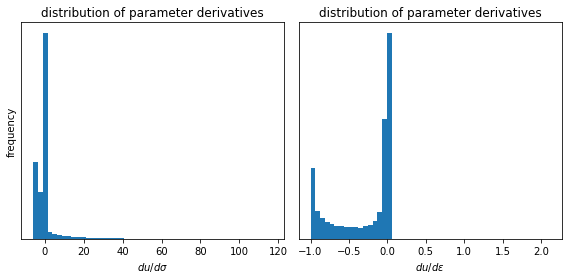

In [26]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.hist(du_dsig, bins=50);
plt.xlabel('$du / d \sigma$')
plt.ylabel('frequency')
plt.yticks([])
plt.title('distribution of parameter derivatives')

plt.subplot(1,2,2)
plt.hist(du_deps, bins=50);
plt.xlabel('$du / d \epsilon$')
plt.yticks([])

plt.title('distribution of parameter derivatives')


plt.tight_layout()

In these cases, variance is a pretty lossy summary, since there are some large but rare outliers! Easier to see if we switch to logarithmic y-scale

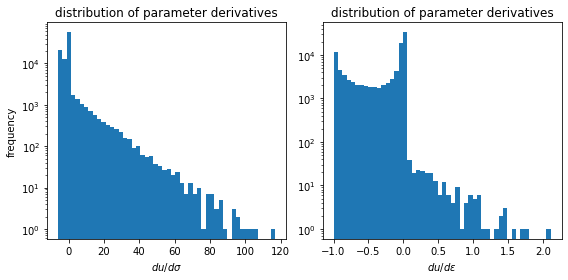

In [27]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.hist(du_dsig, bins=50);
plt.xlabel('$du / d \sigma$')
plt.ylabel('frequency')
plt.yscale('log')
plt.title('distribution of parameter derivatives')

plt.subplot(1,2,2)
plt.hist(du_deps, bins=50);
plt.xlabel('$du / d \epsilon$')
plt.yscale('log')

plt.title('distribution of parameter derivatives')

plt.tight_layout()

### Thermodynamic integration

In [28]:
def du_dl(x, lam, params):
    return vmap(grad(u_fxn, 1), (0, None, None))(x, lam, params)

#### Plug-in estimators for <du/dl>

In [29]:
mean_du_dls = np.array([np.mean(du_dl(x, lam, ref_params)) for (x, lam) in zip(x_k, lambdas)])
stddev_du_dls = np.array([np.std(du_dl(x, lam, ref_params)) for (x, lam) in zip(x_k, lambdas)])

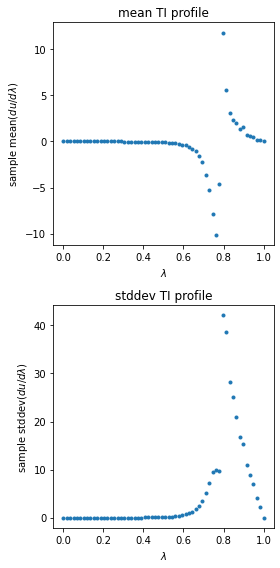

In [30]:
plt.figure(figsize=(4,8))
plt.subplot(2,1,1)

plt.plot(lambdas, mean_du_dls, '.')
plt.xlabel('$\lambda$')
plt.ylabel(r'sample mean($du/d \lambda$)')
plt.title('mean TI profile')

plt.subplot(2,1,2)
plt.plot(lambdas, stddev_du_dls, '.')

plt.xlabel('$\lambda$')
plt.ylabel(r'sample stddev($du/d \lambda$)')
plt.title('stddev TI profile')

plt.tight_layout()

#### Inspect distribution of `du/dl` at challenging value of $\lambda$

Text(0.5, 1.0, 'distribution of $d u / d \\lambda$ at $\\lambda$ = 0.80')

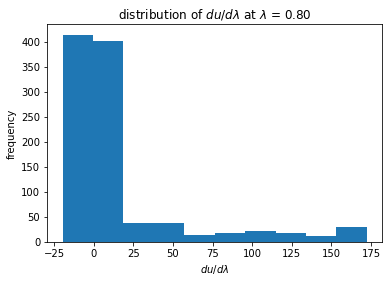

In [31]:
i = np.argmax(stddev_du_dls)
lam = lambdas[i]
plt.hist(du_dl(x_k[i], lam, ref_params))
plt.xlabel('$d u / d \lambda$')
plt.ylabel('frequency')

plt.title('distribution of $d u / d \lambda$ at $\lambda$ = ' + f'{lam:.2f}')

#### Compare TI estimates with MBAR estimates on same samples

Text(0.5, 1.0, 'MBAR vs. TI estimates')

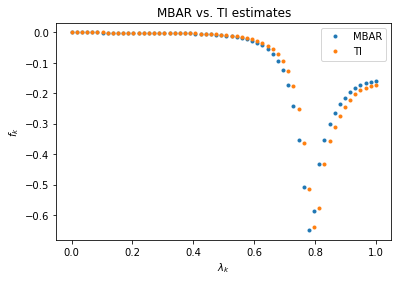

In [32]:
running_ti_estimates = [np.trapz(mean_du_dls[:t], lambdas[:t]) for t in range(len(lambdas))]
plt.plot(lambdas, layer.mbar.f_k, '.', label='MBAR')

plt.plot(lambdas, running_ti_estimates, '.', label='TI')

plt.xlabel('$\lambda_k$')
plt.ylabel('$f_k$')
plt.legend()
plt.title('MBAR vs. TI estimates')

### Repeat estimators over and over again, with fresh samples from scratch

In [33]:
n_samples_per_window = 100

In [34]:
def compute_dG_and_grad_via_thermodynamic_derivative(params, n_samples_per_window):
    """value from thermodynamic integration, grad from thermodynamic derivative"""
    
    # generate new samples
    x_k = [sample(lam, params, n_samples_per_window) for lam in lambdas]
    
    # plug-in estimator for TI curve
    mean_du_dls = np.array([np.mean(du_dl(x, lam, params)) for (x, lam) in zip(x_k, lambdas)])
    dG = np.trapz(mean_du_dls, lambdas)
    assert lambdas[0] == 0
    assert lambdas[-1] == 1
    
    # plug-in estimator for <du/dparams>_1 - <du/dparams>_0
    mean_du_params_1 = np.mean(vec_param_grads(x_k[-1], 1.0, params), 0)
    mean_du_params_0 = np.mean(vec_param_grads(x_k[0], 0.0, params), 0)
    
    return dG, (mean_du_params_1 - mean_du_params_0)

In [35]:
def compute_dG_and_grad_via_autodiff(params, n_samples_per_window):
    """value and grad computed on same samples"""
    
    # generate new samples
    x_k = [sample(lam, params, n_samples_per_window).reshape((n_samples_per_window, 1)) for lam in lambdas]
    
    # pre-process samples
    layer = ReweightingLayer(x_k, u_fxn, params, lambdas)
    
    # compute value_and_grad via autodiff
    return value_and_grad(layer.compute_delta_f)(params)

In [36]:
compute_dG_and_grad_via_thermodynamic_derivative(ref_params, n_samples_per_window)

(DeviceArray(-0.1687485, dtype=float64),
 DeviceArray([-1.26161031, -0.30817247], dtype=float64))

In [37]:
compute_dG_and_grad_via_autodiff(ref_params, n_samples_per_window)

(DeviceArray(-0.15486219, dtype=float64),
 DeviceArray([ 0.07522564, -0.29645624], dtype=float64))

In [38]:
ti_trials = []
for _ in tqdm(range(100)):
    dG, dG_grad = compute_dG_and_grad_via_thermodynamic_derivative(ref_params, n_samples_per_window)
    ti_trials.append((dG, dG_grad))

100%|██████████| 100/100 [01:44<00:00,  1.05s/it]


In [39]:
ti_vals = np.array([trial[0] for trial in ti_trials])
ti_grads = np.array([trial[1] for trial in ti_trials])

np.std(ti_vals, 0), np.std(ti_grads, 0)

(DeviceArray(0.13246809, dtype=float64),
 DeviceArray([0.6318936, 0.0390479], dtype=float64))

In [40]:
mbar_trials = []
for _ in tqdm(range(100)):
    dG, dG_grad = compute_dG_and_grad_via_autodiff(ref_params, n_samples_per_window)
    mbar_trials.append((dG, dG_grad))

100%|██████████| 100/100 [01:39<00:00,  1.01it/s]


In [41]:
mbar_vals = np.array([trial[0] for trial in mbar_trials])
mbar_grads = np.array([trial[1] for trial in mbar_trials])

np.std(mbar_vals, 0), np.std(mbar_grads, 0)

(DeviceArray(0.01177654, dtype=float64),
 DeviceArray([0.10825328, 0.00847919], dtype=float64))

### Analyze variance reduction

In [42]:
# variance(TI) / variance(MBAR)

variance_reduction_dG = np.std(ti_vals)**2 / np.std(mbar_vals, 0)**2
variance_reduction_grad = np.std(ti_grads, 0)**2 / np.std(mbar_grads, 0)**2

print(variance_reduction_dG)
print(variance_reduction_grad)

126.52817021966533
[34.07263976 21.20733708]


In [43]:
# compare with ~exact value and grad
true_delta_f = delta_f_by_quadrature(ref_params)
true_grad_delta_f = approx_fprime(ref_params, delta_f_by_quadrature, 1e-6)
print(true_delta_f)
print(true_grad_delta_f)

-0.16267117502737927
[-0.14740786 -0.3020901 ]


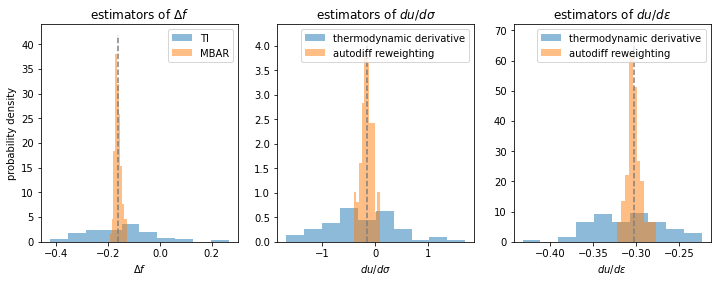

In [44]:
hist_kwargs = dict(alpha=0.5, density=True)

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)

plt.hist(ti_vals, label='TI', **hist_kwargs);
heights = plt.hist(mbar_vals, label='MBAR', **hist_kwargs)[0];

plt.vlines(true_delta_f, 0, max(heights) * 1.1, color='grey', linestyles='--')
plt.title('estimators of $\Delta f$')
plt.ylabel('probability density')
plt.xlabel('$\Delta f$')
plt.legend()

plt.subplot(1,3,2)

plt.hist(ti_grads[:,0], label='thermodynamic derivative', **hist_kwargs);
heights = plt.hist(mbar_grads[:,0], label='autodiff reweighting', **hist_kwargs)[0];
plt.vlines(true_grad_delta_f[0], 0, max(heights) * 1.1, color='grey', linestyles='--')
plt.title('estimators of $du / d \sigma$')
plt.xlabel('$du / d \sigma$')

plt.legend()

plt.subplot(1,3,3)
plt.hist(ti_grads[:,1],label='thermodynamic derivative', **hist_kwargs);
heights = plt.hist(mbar_grads[:,1], label='autodiff reweighting', **hist_kwargs)[0];
plt.vlines(true_grad_delta_f[1], 0, max(heights) * 1.1, color='grey', linestyles='--')
plt.legend()

plt.title('estimators of $du / d \epsilon$')
plt.xlabel('$du / d \epsilon$');